In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
from datetime import datetime 
import numpy as np
import os, random, math, time
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# Warnings
import warnings
warnings.filterwarnings('ignore')

# package
import datetime as datetime
from sklearn.impute import KNNImputer

In [2]:
def read_file(filename):
    df = pd.read_csv(f'{filename}', encoding="utf-8") #"cp949"
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def read_file2(filename):
    df = pd.read_excel(f'{filename}', header=0)
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

filepath = "./data"

def read_files(file_name,chunk_size):
    path = os.getcwd()
    path = os.path.join(path, "data/{}.csv").format(file_name)
    TextFileReader = pd.read_csv(path, chunksize=chunk_size,encoding='cp949')
    dfList = []
    for df in TextFileReader:
        dfList.append(df)

    df = pd.concat(dfList,sort=False)
    return df

def check_NA(df):
    print(f"NA check")
    NA_res = df.isna().sum()
    if NA_res.sum() != 0:
        for idx, i in enumerate(NA_res):
            if i != 0:
                print(df.columns[idx],i,"->",round(i/df.shape[0]*100,3),"%")
    else:
        print("...There's no NA")

In [3]:
dat = read_file(os.path.join(filepath,'merge_s_v5.csv'))
df = deepcopy(dat)

...There are no duplicates
shape: (459, 89)


In [4]:
df["psy_change"]= df["psy_after"]- df["psy_before"]
df["slife_change"]= df["slife_after"]- df["slife_before"]

## 우울증: 점수가 낮은 게 좋은 것 => 점수 차이가 마이너스이면 좋은 것
## 생활관리: 점수가 높은 게 좋은 것 => 점수 차이가 플러스면 좋은 것
## => 점수 차이가 높은 게 좋은 것으로 통일

In [5]:
df["psy_change"] = -df["psy_change"]

In [6]:
df["우울증_변화1"]=np.nan
df.loc[df.psy_before>=df.psy_after, "우울증_변화1"] = "good"
df.loc[df.psy_before<df.psy_after, "우울증_변화1"] = "bad"

In [7]:
df["우울증_변화2"]=np.nan
df.loc[df.psy_before>=df.psy_after, "우울증_변화2"] = "good"
df.loc[df.psy_before<df.psy_after, "우울증_변화2"] = "bad"
df.loc[abs(df.psy_change)<=1, "우울증_변화2"] = "same"

In [8]:
df["생활관리_변화1"]=np.nan
df.loc[df.slife_before>df.slife_after, "생활관리_변화1"] = "bad"
df.loc[df.slife_before<=df.slife_after, "생활관리_변화1"] = "good"

In [9]:
df["생활관리_변화2"]=np.nan
df.loc[df.slife_before>df.slife_after, "생활관리_변화2"] = "bad"
df.loc[df.slife_before<=df.slife_after, "생활관리_변화2"] = "good"
df.loc[abs(df.slife_change)<=1, "생활관리_변화2"] = "same"

In [10]:
ddf = df[df.psy_after.notnull()]
ddf = ddf[['doll_id', 'psy_before', 'psy_after','psy_change','우울증_변화1', '우울증_변화2']]

In [11]:
dff = df[df.slife_after.notnull()]
dff = dff[['doll_id', 'slife_before', 'slife_after', 'slife_change', '생활관리_변화1', "생활관리_변화2"]]

In [12]:
dff = dff.reset_index(drop=True)
ddf = ddf.reset_index(drop=True)

In [13]:
check_NA(dff)

NA check
slife_before 6 -> 3.529 %
slife_change 6 -> 3.529 %
생활관리_변화1 6 -> 3.529 %
생활관리_변화2 6 -> 3.529 %


In [14]:
dff[dff.생활관리_변화1.isnull()]

,doll_id,slife_before,slife_after,slife_change,생활관리_변화1,생활관리_변화2
29,126734,NaN,19.0000,NaN,NaN,NaN
33,126739,NaN,19.0000,NaN,NaN,NaN
47,126775,NaN,16.0000,NaN,NaN,NaN
58,126801,NaN,19.0000,NaN,NaN,NaN
145,127258,NaN,15.0000,NaN,NaN,NaN
162,127407,NaN,23.0000,NaN,NaN,NaN


In [15]:
dff = dff.dropna()

In [16]:
dff

,doll_id,slife_before,slife_after,slife_change,생활관리_변화1,생활관리_변화2
0,126401,16.0000,16.0000,0.0000,good,same
1,126497,19.0000,22.0000,3.0000,good,good
2,126498,18.0000,17.0000,-1.0000,bad,same
3,126500,21.0000,20.0000,-1.0000,bad,same
4,126501,20.0000,19.0000,-1.0000,bad,same
...,...,...,...,...,...,...
165,127468,16.0000,19.0000,3.0000,good,good
166,127517,19.0000,20.0000,1.0000,good,same
167,127542,15.0000,21.0000,6.0000,good,good
168,130982,11.0000,19.0000,8.0000,good,good


In [17]:
check_NA(ddf)

NA check
...There's no NA


In [18]:
ddf.우울증_변화1.value_counts()

good    147
bad      33
Name: 우울증_변화1, dtype: int64

In [19]:
dff.생활관리_변화1.value_counts()

good    120
bad      44
Name: 생활관리_변화1, dtype: int64

In [20]:
df = df[(df.psy_after.notnull())&df.slife_after.notnull()]

In [21]:
df = df.reset_index(drop=True)

In [22]:
df= df[df.생활관리_변화1.notnull()]

# NA imputation

In [23]:
check_NA(df)

NA check
reli_cnt 9 -> 5.488 %
제공서비스 6 -> 3.659 %
주택타입 2 -> 1.22 %
자녀수 3 -> 1.829 %
아들수 89 -> 54.268 %
딸수 95 -> 57.927 %
life1_after 1 -> 0.61 %


In [24]:
df.columns

Index(['doll_id', 'battery', 'active_monitor', '성별', 'birthday', '종교', '기상',
       '아침', '점심', '저녁', '취침', 'is_edited', '아침식전_복용', '아침식후_복용', '점심식전_복용',
       '점심식후_복용', '저녁식전_복용', '저녁식후_복용', '취침전_복용', '환기', '산책', '당뇨', '고지혈',
       '고혈압', 'connection_type', 'no_alarm', 'religion_alarm', 'calender_type',
       'opt_reg_date', 'reli_cnt', '호칭1', '호칭2', '호칭3', '회상', '영어', '음악',
       '종교말씀', '종교음악', '이야기', '퀴즈', '체조', '클래식', '기관', '기관2', 'born', 'age',
       'sex', '수급여부', '세대구성', '제공서비스', '치매', '우울증', '만성복약', '고립', '거동불편',
       '소리반응', '인형관심', '종교유무', '모니터링', '건강관심', '주택타입', '배우자', '자녀', '자녀수',
       '아들수', '딸수', '청결', '식사', '공공방문', '왕래여부', 'doll_score', 'psy_before',
       'psy_after', 'life1_before', 'life1_after', 'psy_before_cat',
       'psy_after_cat', 'slife_before', 'slife_after', 'slife_before_cat',
       'slife_after_cat', '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약',
       '신경과수면제_약', 'med_count', 'psy_change', 'slife_change', '우울증_변화1',
       '우울증_변화2', '생

In [25]:
df = df.drop(['life1_before', 'life1_after','birthday','opt_reg_date', '성별'], axis=1)

In [26]:
for i in df.columns: 
    if df[i].nunique()>50:print(i, '유니크 값 많음') 
    else:  print(i, df[i].dtypes, df[i].unique(), sep=" ")

doll_id 유니크 값 많음
battery int64 [ 92 100  91  94  14   1  10  16  82  13  95  99  98  76  85  30  28  97
  90  96   2   6  89  93  18  88   9  80  44  74  15   3   0   4  64  19
  32]
active_monitor int64 [24 28 48  8]
종교 object ['불교' '무교' '기독교' '천주교']
기상 int64 [ 8  6  7  4  5 15  9 10 11]
아침 int64 [ 9  7  8 10  6 15 11  5]
점심 int64 [12 13 14  9 11 10 15  1 16  3]
저녁 int64 [18 17 19 21 16 20 15  7  8]
취침 int64 [21 22 20 23  0 18  1]
is_edited int64 [0 1]
아침식전_복용 int64 [0 1]
아침식후_복용 int64 [1 0]
점심식전_복용 int64 [0 1]
점심식후_복용 int64 [0 1]
저녁식전_복용 int64 [0 1]
저녁식후_복용 int64 [1 0]
취침전_복용 int64 [0 1]
환기 int64 [1 0]
산책 int64 [0 1]
당뇨 float64 [1. 0.]
고지혈 float64 [0. 1.]
고혈압 float64 [0. 1.]
connection_type object ['CAT1']
no_alarm float64 [0. 1.]
religion_alarm float64 [1. 0.]
calender_type float64 [1. 0.]
reli_cnt float64 [ 2.  1. nan  4.  3.]
호칭1 float64 [1.]
호칭2 float64 [0.]
호칭3 float64 [0.]
회상 float64 [1. 0.]
영어 float64 [0.]
음악 float64 [1. 0.]
종교말씀 float64 [0.]
종교음악 float64 [0.]
이야기 float64 [1. 

In [27]:
df = df.drop(['connection_type', '호칭1', '호칭2', '호칭3', '영어', 
              '종교말씀', '종교음악', '퀴즈', '체조', '클래식', 
             'born'], axis=1)

In [28]:
check_NA(df)

NA check
reli_cnt 9 -> 5.488 %
제공서비스 6 -> 3.659 %
주택타입 2 -> 1.22 %
자녀수 3 -> 1.829 %
아들수 89 -> 54.268 %
딸수 95 -> 57.927 %


In [29]:
df.reli_cnt.value_counts()

1.0000    135
2.0000     18
4.0000      1
3.0000      1
Name: reli_cnt, dtype: int64

In [30]:
df['reli_cnt'] = df['reli_cnt'].fillna(1)

In [31]:
df.제공서비스.value_counts()

노인돌봄기본서비스          68
없음                 65
기타서비스              17
응급안전알림서비스           3
홀몸어르신안심서비스(IOT)     3
노인돌봄종합서비스           1
재가노인지원사업            1
Name: 제공서비스, dtype: int64

In [32]:
df.loc[df.제공서비스=="없음", '제공서비스']=0
df.loc[df.제공서비스=="노인돌봄기본서비스", '제공서비스']=1
df.loc[df.제공서비스=="기타서비스", '제공서비스']=1
df.loc[df.제공서비스=="응급안전알림서비스", '제공서비스']=1
df.loc[df.제공서비스=="홀몸어르신안심서비스(IOT)", '제공서비스']=1
df.loc[df.제공서비스=="노인돌봄종합서비스", '제공서비스']=1
df.loc[df.제공서비스=="재가노인지원사업", '제공서비스']=1
df['제공서비스']= df['제공서비스'].fillna(0)
df['제공서비스'] = df['제공서비스'].astype('int')

In [33]:
df.주택타입.value_counts()

주택     96
빌라     45
아파트    20
기타      1
Name: 주택타입, dtype: int64

In [34]:
df.loc[df.주택타입=="기타", '주택타입']='주택'
df['주택타입'] = df['주택타입'].fillna("주택")

In [35]:
df.자녀수.value_counts()

0.0000    57
2.0000    34
1.0000    26
3.0000    23
4.0000    11
6.0000     5
5.0000     3
7.0000     2
Name: 자녀수, dtype: int64

In [36]:
df[['자녀수','아들수', '딸수']]

,자녀수,아들수,딸수
0,3.0000,1.0000,2.0000
1,2.0000,1.0000,1.0000
2,0.0000,NaN,NaN
3,3.0000,NaN,3.0000
4,4.0000,3.0000,1.0000
...,...,...,...
165,5.0000,4.0000,1.0000
166,2.0000,NaN,2.0000
167,2.0000,2.0000,NaN
168,1.0000,1.0000,NaN


In [37]:
df['자녀수'] = df['자녀수'].fillna(0)
df['아들수'] = df['아들수'].fillna(0)
df['딸수'] = df['딸수'].fillna(0)

In [38]:
df['아들딸'] = df.아들수+df.딸수

In [39]:
df[['자녀수','아들수', '딸수', '아들딸']][df.아들딸!=df.자녀수]

,자녀수,아들수,딸수,아들딸
12,2.0000,0.0000,0.0000,0.0000
21,1.0000,0.0000,0.0000,0.0000
69,1.0000,0.0000,0.0000,0.0000
107,1.0000,0.0000,0.0000,0.0000
113,1.0000,0.0000,0.0000,0.0000
117,1.0000,0.0000,0.0000,0.0000
142,1.0000,0.0000,0.0000,0.0000
160,1.0000,0.0000,0.0000,0.0000


In [40]:
df = df.drop(['아들딸'], axis=1)

In [41]:
check_NA(df)

NA check
...There's no NA


In [42]:
df.columns

Index(['doll_id', 'battery', 'active_monitor', '종교', '기상', '아침', '점심', '저녁',
       '취침', 'is_edited', '아침식전_복용', '아침식후_복용', '점심식전_복용', '점심식후_복용',
       '저녁식전_복용', '저녁식후_복용', '취침전_복용', '환기', '산책', '당뇨', '고지혈', '고혈압',
       'no_alarm', 'religion_alarm', 'calender_type', 'reli_cnt', '회상', '음악',
       '이야기', '기관', '기관2', 'age', 'sex', '수급여부', '세대구성', '제공서비스', '치매', '우울증',
       '만성복약', '고립', '거동불편', '소리반응', '인형관심', '종교유무', '모니터링', '건강관심', '주택타입',
       '배우자', '자녀', '자녀수', '아들수', '딸수', '청결', '식사', '공공방문', '왕래여부',
       'doll_score', 'psy_before', 'psy_after', 'psy_before_cat',
       'psy_after_cat', 'slife_before', 'slife_after', 'slife_before_cat',
       'slife_after_cat', '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약',
       '신경과수면제_약', 'med_count', 'psy_change', 'slife_change', '우울증_변화1',
       '우울증_변화2', '생활관리_변화1', '생활관리_변화2'],
      dtype='object')

In [43]:
for i in df.columns: 
    if df[i].nunique()>50:print(i, '유니크 값 많음') 
    else:  print(i, df[i].dtypes, df[i].unique(), sep=" ")

doll_id 유니크 값 많음
battery int64 [ 92 100  91  94  14   1  10  16  82  13  95  99  98  76  85  30  28  97
  90  96   2   6  89  93  18  88   9  80  44  74  15   3   0   4  64  19
  32]
active_monitor int64 [24 28 48  8]
종교 object ['불교' '무교' '기독교' '천주교']
기상 int64 [ 8  6  7  4  5 15  9 10 11]
아침 int64 [ 9  7  8 10  6 15 11  5]
점심 int64 [12 13 14  9 11 10 15  1 16  3]
저녁 int64 [18 17 19 21 16 20 15  7  8]
취침 int64 [21 22 20 23  0 18  1]
is_edited int64 [0 1]
아침식전_복용 int64 [0 1]
아침식후_복용 int64 [1 0]
점심식전_복용 int64 [0 1]
점심식후_복용 int64 [0 1]
저녁식전_복용 int64 [0 1]
저녁식후_복용 int64 [1 0]
취침전_복용 int64 [0 1]
환기 int64 [1 0]
산책 int64 [0 1]
당뇨 float64 [1. 0.]
고지혈 float64 [0. 1.]
고혈압 float64 [0. 1.]
no_alarm float64 [0. 1.]
religion_alarm float64 [1. 0.]
calender_type float64 [1. 0.]
reli_cnt float64 [2. 1. 4. 3.]
회상 float64 [1. 0.]
음악 float64 [1. 0.]
이야기 float64 [1. 0.]
기관 object ['구로']
기관2 object ['온수어르신복지관' '궁동종합사회복지관' '구로어르신돌봄통합센터' '동주민센터' '화원종합사회복지관' '구로건강복지센터'
 '구로노인복지관']
age int64 [82 77 72 68 92 79 7

In [44]:
int_col = ['no_alarm', 'religion_alarm', 'calender_type', 'reli_cnt',
          '회상', '음악', '이야기', 
           '치매', '우울증','만성복약', '고립', '거동불편', '소리반응', '인형관심', '종교유무','모니터링','건강관심',
           '배우자', '자녀', '자녀수', '아들수', '딸수','공공방문',
           'doll_score', 'psy_before', 'psy_after','slife_before', 'slife_after',
           '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약','신경과수면제_약', 
           'med_count', 'psy_change', 'slife_change', 
          ]

In [45]:
for i in int_col: 
    df[i]= df[i].astype("int")

In [46]:
check_NA(df)

NA check
...There's no NA


# log column preprocessing

In [47]:
merge = pd.read_csv('data/merge_s_v5.csv')
log = pd.read_csv('data/log_merge1.csv')
surv_id = deepcopy(df)

In [48]:
merge = merge[merge.doll_id.isin(surv_id.doll_id.unique())].reset_index(drop=True)

In [49]:
log.head(3)

,date,doll_id,stroke,hand_hold,knock,human_detection,gymnastics,brain_timer,battery,last_none_action_time_passed,logdoll_yn,consume_cnt,drug_yn,emrg_cnt,emrg_yn
0,2019-04-01,124017,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,84.7500,"3,512.0000",1,1.0000,1,0.0000,0
1,2019-04-02,124017,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,93.6401,"4,955.0000",1,1.0000,1,0.0000,0
2,2019-04-03,124017,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,94.9103,"6,396.0000",1,1.0000,1,0.0000,0


In [50]:
log.shape

(927578, 15)

In [51]:
log2 = log[log.doll_id.isin(surv_id.doll_id.unique())]
log2.head()

,date,doll_id,stroke,hand_hold,knock,human_detection,gymnastics,brain_timer,battery,last_none_action_time_passed,logdoll_yn,consume_cnt,drug_yn,emrg_cnt,emrg_yn
254715,2019-08-21,126401,13.0000,6.0000,7.0000,121.0000,3.0000,4.0000,92.1348,0.0000,1,0.0000,0,0.0000,0
254716,2019-08-22,126401,31.0000,2.0000,7.0000,85.0000,0.0000,2.0000,57.6667,0.0000,1,1.0000,1,0.0000,0
254717,2019-08-23,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0
254718,2019-08-24,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0
254719,2019-08-25,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0


In [52]:
log2.doll_id.nunique()

164

In [53]:
period = []
for u in log2.doll_id.unique():
    origin = pd.to_datetime(np.min(log2.loc[log2.doll_id == u,'date']))
    end = pd.to_datetime(np.max(log2.loc[log2.doll_id == u,'date']))
    period.append((end-origin).days +1)

In [54]:
period = pd.DataFrame({'doll_id': log2.doll_id.unique(),'period':period})
period.head()

,doll_id,period
0,126401,631
1,126497,619
2,126498,101
3,126500,619
4,126501,619


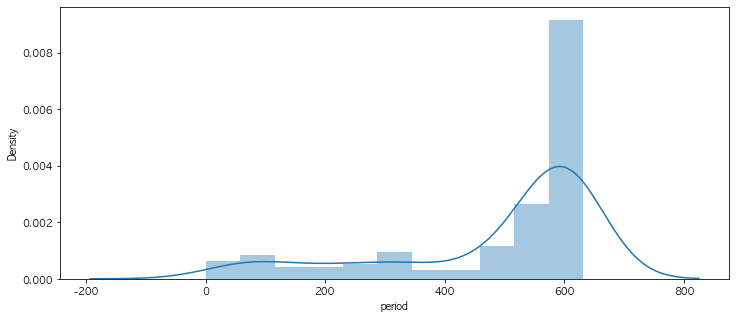

In [55]:
plt.figure(figsize=(12,5))
sns.distplot(period.period)
plt.show()

In [56]:
print(np.sum(period.period <10))
print(np.sum(period.period <31))
print(np.sum((period.period >=31)&(period.period < 184)))
print(np.sum((period.period >=184)&(period.period < 366)))
print(np.sum(period.period >=366))

1
1
18
19
126


In [57]:
print(np.sum(period.period <10)/len(period))
print(np.sum(period.period <31)/len(period))
print(np.sum((period.period >=31)&(period.period < 184))/len(period))
print(np.sum((period.period >=184)&(period.period < 366))/len(period))
print(np.sum(period.period >=366)/len(period))

0.006097560975609756
0.006097560975609756
0.10975609756097561
0.11585365853658537
0.7682926829268293


### 로그 데이터 설문조사 기간으로 자르기 

- 사전: 2019.09.09
- 사후: 2019.12.20 (사용 3개월 후)

In [58]:
merge.columns

Index(['doll_id', 'battery', 'active_monitor', '성별', 'birthday', '종교', '기상',
       '아침', '점심', '저녁', '취침', 'is_edited', '아침식전_복용', '아침식후_복용', '점심식전_복용',
       '점심식후_복용', '저녁식전_복용', '저녁식후_복용', '취침전_복용', '환기', '산책', '당뇨', '고지혈',
       '고혈압', 'connection_type', 'no_alarm', 'religion_alarm', 'calender_type',
       'opt_reg_date', 'reli_cnt', '호칭1', '호칭2', '호칭3', '회상', '영어', '음악',
       '종교말씀', '종교음악', '이야기', '퀴즈', '체조', '클래식', '기관', '기관2', 'born', 'age',
       'sex', '수급여부', '세대구성', '제공서비스', '치매', '우울증', '만성복약', '고립', '거동불편',
       '소리반응', '인형관심', '종교유무', '모니터링', '건강관심', '주택타입', '배우자', '자녀', '자녀수',
       '아들수', '딸수', '청결', '식사', '공공방문', '왕래여부', 'doll_score', 'psy_before',
       'psy_after', 'life1_before', 'life1_after', 'psy_before_cat',
       'psy_after_cat', 'slife_before', 'slife_after', 'slife_before_cat',
       'slife_after_cat', '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약',
       '신경과수면제_약', 'med_count'],
      dtype='object')

In [59]:
log.head()

,date,doll_id,stroke,hand_hold,knock,human_detection,gymnastics,brain_timer,battery,last_none_action_time_passed,logdoll_yn,consume_cnt,drug_yn,emrg_cnt,emrg_yn
0,2019-04-01,124017,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,84.7500,"3,512.0000",1,1.0000,1,0.0000,0
1,2019-04-02,124017,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,93.6401,"4,955.0000",1,1.0000,1,0.0000,0
2,2019-04-03,124017,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,94.9103,"6,396.0000",1,1.0000,1,0.0000,0
3,2019-04-04,124017,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,93.1409,0.0000,1,1.0000,1,1.0000,1
4,2019-04-05,124017,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,90.2335,0.0000,1,1.0000,1,0.0000,0


In [60]:
pd.options.display.max_rows = 180

In [61]:
survey_log = log[log.doll_id.isin(surv_id.doll_id.unique())].reset_index(drop=True)

In [62]:
survey_log.head()

,date,doll_id,stroke,hand_hold,knock,human_detection,gymnastics,brain_timer,battery,last_none_action_time_passed,logdoll_yn,consume_cnt,drug_yn,emrg_cnt,emrg_yn
0,2019-08-21,126401,13.0000,6.0000,7.0000,121.0000,3.0000,4.0000,92.1348,0.0000,1,0.0000,0,0.0000,0
1,2019-08-22,126401,31.0000,2.0000,7.0000,85.0000,0.0000,2.0000,57.6667,0.0000,1,1.0000,1,0.0000,0
2,2019-08-23,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0
3,2019-08-24,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0
4,2019-08-25,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0


In [63]:
survey_log.shape

(80076, 15)

In [64]:
survey_log.doll_id.nunique()

164

#### 파생변수 만들 수 있는 변수 
- stroke: 인형 머리 쓰다듬 횟수
- hand_hold: 인형 손 버튼 누름 횟수
- knock: 인형 등 두드림 횟수
- human_detection: 인체 감지 횟수
- gymnastics: 체조 실행 횟수
- brain_timer: 퀴즈 실행 횟수
- last_none_action_time_passed: 마지막 활동 감지 시간
- consume_cnt: 약 복용수
- emrg_cnt: 푸쉬 알람수

- battery: 변수에서 제외

In [65]:
survey_log.columns

Index(['date', 'doll_id', 'stroke', 'hand_hold', 'knock', 'human_detection',
       'gymnastics', 'brain_timer', 'battery', 'last_none_action_time_passed',
       'logdoll_yn', 'consume_cnt', 'drug_yn', 'emrg_cnt', 'emrg_yn'],
      dtype='object')

In [66]:
col = ['stroke', 'hand_hold', 'knock', 'human_detection',
       'gymnastics', 'brain_timer',  
        'consume_cnt', 'emrg_cnt']

In [67]:
survey_log.head()

,date,doll_id,stroke,hand_hold,knock,human_detection,gymnastics,brain_timer,battery,last_none_action_time_passed,logdoll_yn,consume_cnt,drug_yn,emrg_cnt,emrg_yn
0,2019-08-21,126401,13.0000,6.0000,7.0000,121.0000,3.0000,4.0000,92.1348,0.0000,1,0.0000,0,0.0000,0
1,2019-08-22,126401,31.0000,2.0000,7.0000,85.0000,0.0000,2.0000,57.6667,0.0000,1,1.0000,1,0.0000,0
2,2019-08-23,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0
3,2019-08-24,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0
4,2019-08-25,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0


In [68]:
survey_log.emrg_cnt.value_counts()

0.0000    75460
1.0000     4613
2.0000        2
3.0000        1
Name: emrg_cnt, dtype: int64

In [69]:
tmp = survey_log[survey_log.doll_id ==126401]
corrdf = tmp[col].corr()

In [70]:
for c in col:
    corrdf[c] = 0

In [71]:
for d in survey_log.doll_id.unique():
    tmp = survey_log[survey_log.doll_id ==d]
    tmp = tmp[col].corr().fillna(0)
    corrdf = tmp[col].corr() + corrdf 

In [72]:
corrdf

,stroke,hand_hold,knock,human_detection,gymnastics,brain_timer,consume_cnt,emrg_cnt
stroke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hand_hold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
knock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
human_detection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gymnastics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brain_timer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
consume_cnt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emrg_cnt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 기간나누고 파생변수 생성 시작

In [73]:
set(surv_id.doll_id)-set(survey_log.doll_id)

set()

### 1. 전 기간에 대해 합치기 

사전: 2019.09.09 사후: 2019.12.20 (사용 3개월 후)

In [74]:
survey_log2 = survey_log[(survey_log.date>='2019-09-09')&(survey_log.date<= '2019-12-20')]
survey_log2.head()

,date,doll_id,stroke,hand_hold,knock,human_detection,gymnastics,brain_timer,battery,last_none_action_time_passed,logdoll_yn,consume_cnt,drug_yn,emrg_cnt,emrg_yn
19,2019-09-09,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0
20,2019-09-10,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0
21,2019-09-11,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0
22,2019-09-12,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0
23,2019-09-13,126401,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0


In [75]:
survey_log2.describe()

,doll_id,stroke,hand_hold,knock,human_detection,gymnastics,brain_timer,battery,last_none_action_time_passed,logdoll_yn,consume_cnt,drug_yn,emrg_cnt,emrg_yn
count,"13,802.0000","13,802.0000","13,802.0000","13,802.0000","13,802.0000","13,802.0000","13,802.0000","13,802.0000","13,802.0000","13,802.0000","13,802.0000","13,802.0000","13,802.0000","13,802.0000"
mean,"126,852.4705",7.2958,4.8852,11.2579,197.3631,0.3639,0.3927,66.9633,45.4361,0.7458,0.3867,0.3417,0.0335,0.0335
std,205.0021,49.8271,17.8445,43.4643,456.2017,1.5321,1.4919,43.3103,681.6572,0.4354,0.5797,0.4743,0.1799,0.1799
min,"126,401.0000",-89.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,"126,743.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,"126,864.0000",0.0000,0.0000,0.0000,40.0000,0.0000,0.0000,99.0181,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
75%,"126,973.0000",3.0000,2.0000,4.0000,243.7500,0.0000,0.0000,100.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000
max,"127,468.0000","1,406.0000",456.0000,797.0000,"5,854.0000",54.0000,35.0000,100.0000,"51,739.0000",1.0000,4.0000,1.0000,1.0000,1.0000


In [76]:
# 음수인 stroke filtering 
sum(survey_log2.stroke<0), np.min(survey_log2.stroke[survey_log2.stroke>=0])

(1, 0.0)

In [77]:
survey_log2.stroke[survey_log2.stroke<0] = 0

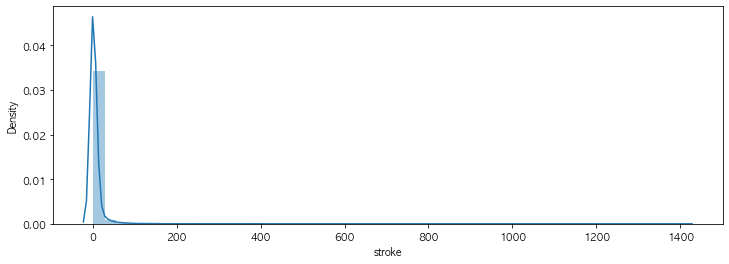

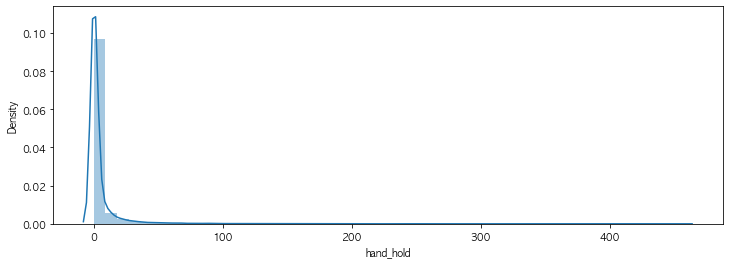

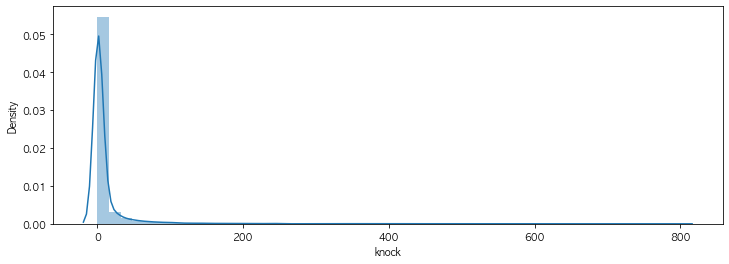

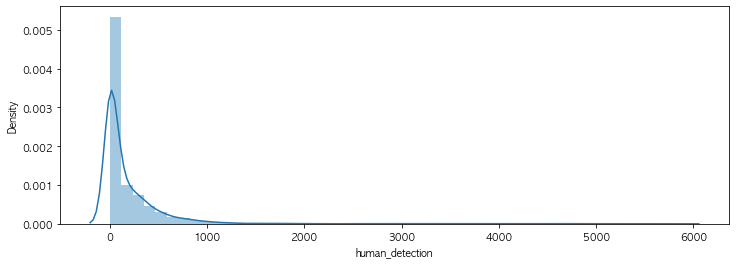

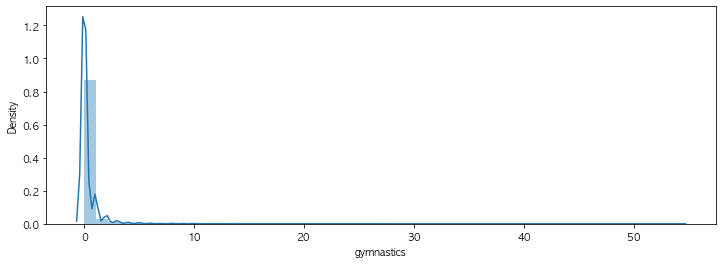

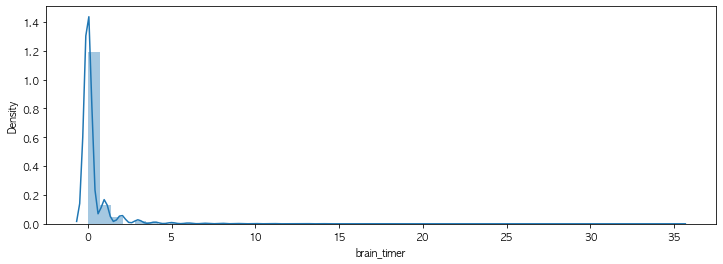

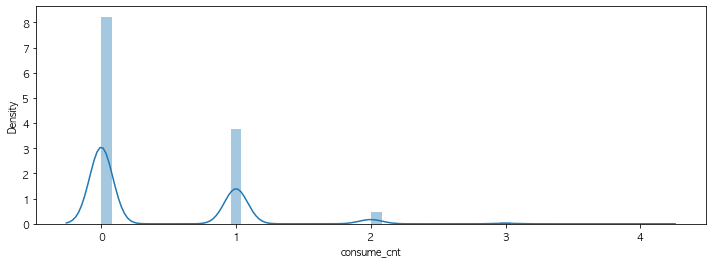

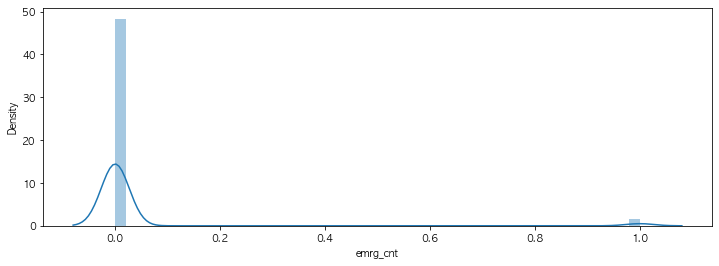

In [78]:
for c in col:
    plt.figure(figsize=(12,4))
    sns.distplot(survey_log2[c], bins = 50)
    plt.show()

## sum

In [79]:
survey_log2[survey_log2.emrg_cnt>1] = 1

In [80]:
col = [ 'stroke', 'hand_hold', 'knock', 'human_detection','gymnastics', 'brain_timer','logdoll_yn', 'consume_cnt', 'drug_yn','emrg_cnt']
data = survey_log2.groupby('doll_id').sum()[col]
data.columns =list(map(lambda x: x+'_sum',col ))

In [81]:
data.head(3)

,stroke_sum,hand_hold_sum,knock_sum,human_detection_sum,gymnastics_sum,brain_timer_sum,logdoll_yn_sum,consume_cnt_sum,drug_yn_sum,emrg_cnt_sum
doll_id,,,,,,,,,,
126401,"1,442.0000","1,908.0000","4,631.0000","50,060.0000",59.0000,59.0000,82,97.0000,82,0.0000
126497,65.0000,47.0000,209.0000,"9,095.0000",14.0000,11.0000,67,60.0000,58,3.0000
126498,1.0000,0.0000,2.0000,152.0000,0.0000,0.0000,12,4.0000,4,2.0000


In [82]:
data.shape

(160, 10)

In [83]:
survey_log2.emrg_cnt.value_counts()

0.0000    13340
1.0000      462
Name: emrg_cnt, dtype: int64

- logdoll_yn + drug_yn 중 하나라도 1이면 1로 보고 90일 중에 며칠이나 이 변수를 썼나 (인형을 사용한 일수 비율)
- logdoll_yn -> human_detection 만 1이고 나머지는 0인것 빼고
- 어떤 사람은 세달 동안은 82 인데 한달동안 20일수도 있으니 사용기간 반영하기
- drug_yn?
- emrg_cnt 하루에 여러번 뜨는게 의미가 없을 것 같아서 더미변수화 하는게 나아보인다

여기서는 battery, last_none_Action_time_passed 사용하지 않음

In [84]:
survey_log2.columns

Index(['date', 'doll_id', 'stroke', 'hand_hold', 'knock', 'human_detection',
       'gymnastics', 'brain_timer', 'battery', 'last_none_action_time_passed',
       'logdoll_yn', 'consume_cnt', 'drug_yn', 'emrg_cnt', 'emrg_yn'],
      dtype='object')

## max

In [85]:
col2 = ['stroke', 'hand_hold', 'knock', 'human_detection','gymnastics', 'brain_timer']
tmp = survey_log2.groupby('doll_id').max()[col2]
tmp.columns = list(map(lambda x: x+'_max',col2))

In [86]:
data.shape, tmp.shape

((160, 10), (160, 6))

In [87]:
data = pd.merge(data,tmp, on ='doll_id')

-> max 변수를 없애도 될 것 같다...!

In [88]:
survey_log2['week'] = pd.DatetimeIndex(survey_log2.date).to_period("W")
#주별번호매기기
survey_log2["week_num"] = 0
for idx,w in enumerate (survey_log2.week.unique()):
    survey_log2.loc[survey_log2.week == w,"week_num"] = idx

In [89]:
survey_log2.groupby(['doll_id','week_num']).sum().reset_index().head()

,doll_id,week_num,stroke,hand_hold,knock,human_detection,gymnastics,brain_timer,battery,last_none_action_time_passed,logdoll_yn,consume_cnt,drug_yn,emrg_cnt,emrg_yn
0,126401,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0
1,126401,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0
2,126401,2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.0000,0
3,126401,3,158.0000,0.0000,479.0000,"2,982.0000",3.0000,2.0000,542.4952,0.0000,7,9.0000,7,0.0000,0
4,126401,4,127.0000,6.0000,470.0000,"4,031.0000",3.0000,2.0000,586.5797,0.0000,7,10.0000,7,0.0000,0


In [90]:
survey_log2.groupby(['doll_id','week_num']).sum().reset_index().shape

(2042, 15)

In [91]:
survey_wk = survey_log2.groupby(['doll_id','week_num']).sum().reset_index().groupby('doll_id').max()-survey_log2.groupby(['doll_id','week_num']).sum().reset_index().groupby('doll_id').min()
tmp = survey_wk[['stroke','hand_hold','knock','human_detection','gymnastics','brain_timer']]
tmp.columns = list(map(lambda x: x+'_wk',['stroke','hand_hold','knock','human_detection','gymnastics','brain_timer']))

In [92]:
data = pd.merge(data,tmp, on ='doll_id')

In [93]:
data.columns

Index(['stroke_sum', 'hand_hold_sum', 'knock_sum', 'human_detection_sum',
       'gymnastics_sum', 'brain_timer_sum', 'logdoll_yn_sum',
       'consume_cnt_sum', 'drug_yn_sum', 'emrg_cnt_sum', 'stroke_max',
       'hand_hold_max', 'knock_max', 'human_detection_max', 'gymnastics_max',
       'brain_timer_max', 'stroke_wk', 'hand_hold_wk', 'knock_wk',
       'human_detection_wk', 'gymnastics_wk', 'brain_timer_wk'],
      dtype='object')

In [94]:
for i, c1 in enumerate (data.columns):
    for j, c2 in enumerate (data.columns):
        if (i> j )& (abs(data.corr().iloc[i,j])>=0.8):
            print(c1," + ",c2, ' : ', np.round(data.corr().iloc[i,j],4))

brain_timer_sum  +  hand_hold_sum  :  0.8014
drug_yn_sum  +  consume_cnt_sum  :  0.9853
stroke_max  +  stroke_sum  :  0.9688
hand_hold_max  +  hand_hold_sum  :  0.8551
knock_max  +  knock_sum  :  0.9162
gymnastics_max  +  gymnastics_sum  :  0.8418
brain_timer_max  +  gymnastics_sum  :  0.8146
stroke_wk  +  stroke_sum  :  0.9934
stroke_wk  +  stroke_max  :  0.9813
hand_hold_wk  +  hand_hold_sum  :  0.9227
hand_hold_wk  +  hand_hold_max  :  0.9449
knock_wk  +  knock_sum  :  0.9388
knock_wk  +  knock_max  :  0.9712
human_detection_wk  +  human_detection_max  :  0.9414
gymnastics_wk  +  stroke_sum  :  0.8822
gymnastics_wk  +  gymnastics_sum  :  0.9133
gymnastics_wk  +  stroke_max  :  0.8683
gymnastics_wk  +  gymnastics_max  :  0.9094
gymnastics_wk  +  stroke_wk  :  0.8801
brain_timer_wk  +  gymnastics_sum  :  0.8214
brain_timer_wk  +  brain_timer_sum  :  0.9221
brain_timer_wk  +  brain_timer_max  :  0.9233


- stroke_wk  +  stroke_sum  :  0.9934
- stroke_wk  +  stroke_max  :  0.9813
- stroke_max  +  stroke_sum  :  0.9688
- 
- hand_hold_wk  +  hand_hold_sum  :  0.9227
- hand_hold_wk  +  hand_hold_max  :  0.9449
- hand_hold_max  +  hand_hold_sum  :  0.8551
- 
- knock_wk  +  knock_sum  :  0.9388
- knock_wk  +  knock_max  :  0.9712
- knock_max  +  knock_sum  :  0.9162
- 
- human_detection_wk  +  human_detection_max  :  0.9414
- 
- brain_timer_wk  +  brain_timer_sum  :  0.9221
- brain_timer_wk  +  brain_timer_max  :  0.9233
- brain_timer_max  +  gymnastics_sum  :  0.8146
- 
- gymnastics_max  +  gymnastics_sum  :  0.8418
- gymnastics_wk  +  gymnastics_sum  :  0.9133
- gymnastics_wk  +  gymnastics_max  :  0.9094

다 필요 없을 듯! 하나만 고르자!<br>

이것 이외에는 ...
- brain_timer_sum  +  hand_hold_sum  :  0.8014
- drug_yn_sum  +  consume_cnt_sum  :  0.9853
- gymnastics_wk  +  stroke_sum(max,wk)  :  0.8822
- brain_timer_wk  +  gymnastics_sum  :  0.8214

In [95]:
tmp = pd.DataFrame()
col2 = ['stroke', 'hand_hold', 'knock', 'human_detection','gymnastics', 'brain_timer']
col_sum = list(map(lambda x: x+'_sum',col2))
for c in col2:
    tmp[c+'_mean'] = data[c+'_sum']/data.logdoll_yn_sum

In [96]:
tmp.shape

(160, 6)

In [97]:
tmp.head()

,stroke_mean,hand_hold_mean,knock_mean,human_detection_mean,gymnastics_mean,brain_timer_mean
doll_id,,,,,,
126401,17.5854,23.2683,56.4756,610.4878,0.7195,0.7195
126497,0.9701,0.7015,3.1194,135.7463,0.2090,0.1642
126498,0.0833,0.0000,0.1667,12.6667,0.0000,0.0000
126500,5.4127,3.1587,7.0000,371.7619,0.3175,0.4921
126501,0.0941,0.3176,0.2588,50.0588,0.0706,0.0706


In [98]:
data.shape

(160, 22)

In [99]:
data.head()

,stroke_sum,hand_hold_sum,knock_sum,human_detection_sum,gymnastics_sum,brain_timer_sum,logdoll_yn_sum,consume_cnt_sum,drug_yn_sum,emrg_cnt_sum,stroke_max,hand_hold_max,knock_max,human_detection_max,gymnastics_max,brain_timer_max,stroke_wk,hand_hold_wk,knock_wk,human_detection_wk,gymnastics_wk,brain_timer_wk
doll_id,,,,,,,,,,,,,,,,,,,,,,
126401,"1,442.0000","1,908.0000","4,631.0000","50,060.0000",59.0000,59.0000,82,97.0000,82,0.0000,57.0000,262.0000,170.0000,"1,132.0000",3.0000,4.0000,190.0000,503.0000,756.0000,"5,699.0000",11.0000,13.0000
126497,65.0000,47.0000,209.0000,"9,095.0000",14.0000,11.0000,67,60.0000,58,3.0000,5.0000,4.0000,28.0000,412.0000,1.0000,4.0000,14.0000,9.0000,53.0000,"2,013.0000",3.0000,4.0000
126498,1.0000,0.0000,2.0000,152.0000,0.0000,0.0000,12,4.0000,4,2.0000,1.0000,0.0000,1.0000,31.0000,0.0000,0.0000,1.0000,0.0000,1.0000,119.0000,0.0000,0.0000
126500,341.0000,199.0000,441.0000,"23,421.0000",20.0000,31.0000,63,7.0000,7,0.0000,58.0000,17.0000,34.0000,526.0000,4.0000,8.0000,190.0000,54.0000,69.0000,"3,001.0000",8.0000,9.0000
126501,8.0000,27.0000,22.0000,"4,255.0000",6.0000,6.0000,85,21.0000,21,1.0000,3.0000,20.0000,13.0000,185.0000,1.0000,2.0000,3.0000,20.0000,13.0000,694.0000,2.0000,2.0000


In [100]:
data = pd.merge(data,tmp, on ='doll_id')

In [101]:
data = data[['stroke_sum', 'hand_hold_sum', 'knock_sum', 'human_detection_sum',
       'gymnastics_sum', 'brain_timer_sum', 'logdoll_yn_sum',
       'consume_cnt_sum', 'drug_yn_sum', 'emrg_cnt_sum','stroke_mean',
       'hand_hold_mean', 'knock_mean', 'human_detection_mean',
       'gymnastics_mean', 'brain_timer_mean']]

In [102]:
for i, c1 in enumerate (data.columns):
    for j, c2 in enumerate (data.columns):
        if (i> j )& (abs(data.corr().iloc[i,j])>=0.8):
            print(c1," + ",c2, ' : ', np.round(data.corr().iloc[i,j],4))

brain_timer_sum  +  hand_hold_sum  :  0.8014
drug_yn_sum  +  consume_cnt_sum  :  0.9853
stroke_mean  +  stroke_sum  :  0.9984
hand_hold_mean  +  hand_hold_sum  :  0.9469
knock_mean  +  knock_sum  :  0.9841
human_detection_mean  +  human_detection_sum  :  0.9767
gymnastics_mean  +  gymnastics_sum  :  0.9556
brain_timer_mean  +  brain_timer_sum  :  0.9598


mean도 correlation 높다!<br>
mean 과 sum 중 고르면 될 것 같다.

In [103]:
data = data[['stroke_sum', 'hand_hold_sum', 'knock_sum', 'human_detection_sum',
       'gymnastics_sum', 'brain_timer_sum', 'logdoll_yn_sum',
       'consume_cnt_sum', 'drug_yn_sum', 'emrg_cnt_sum']]

In [104]:
data.head(3)

,stroke_sum,hand_hold_sum,knock_sum,human_detection_sum,gymnastics_sum,brain_timer_sum,logdoll_yn_sum,consume_cnt_sum,drug_yn_sum,emrg_cnt_sum
doll_id,,,,,,,,,,
126401,"1,442.0000","1,908.0000","4,631.0000","50,060.0000",59.0000,59.0000,82,97.0000,82,0.0000
126497,65.0000,47.0000,209.0000,"9,095.0000",14.0000,11.0000,67,60.0000,58,3.0000
126498,1.0000,0.0000,2.0000,152.0000,0.0000,0.0000,12,4.0000,4,2.0000


In [105]:
data.shape

(160, 10)

# 사용한 일수
logdoll_yn + drug_yn 중 하나라도 1이면 1로 보고 90일 중에 며칠이나 이 변수를 썼나 (인형을 사용한 일수 비율)

In [106]:
survey_log2['yn'] = 0
survey_log2.loc[(survey_log2.logdoll_yn ==1) |(survey_log2.drug_yn ==1),'yn'] = 1
tmp = survey_log2.groupby('doll_id').sum()['yn']

In [107]:
data = pd.merge(data,tmp, on ='doll_id')

In [108]:
data.corr().loc[['logdoll_yn_sum','drug_yn_sum','yn'],['logdoll_yn_sum','drug_yn_sum','yn']]

,logdoll_yn_sum,drug_yn_sum,yn
logdoll_yn_sum,1.0000,0.5004,1.0000
drug_yn_sum,0.5004,1.0000,0.5004
yn,1.0000,0.5004,1.0000


In [109]:
data.head(3)

,stroke_sum,hand_hold_sum,knock_sum,human_detection_sum,gymnastics_sum,brain_timer_sum,logdoll_yn_sum,consume_cnt_sum,drug_yn_sum,emrg_cnt_sum,yn
doll_id,,,,,,,,,,,
126401,"1,442.0000","1,908.0000","4,631.0000","50,060.0000",59.0000,59.0000,82,97.0000,82,0.0000,82
126497,65.0000,47.0000,209.0000,"9,095.0000",14.0000,11.0000,67,60.0000,58,3.0000,67
126498,1.0000,0.0000,2.0000,152.0000,0.0000,0.0000,12,4.0000,4,2.0000,12


In [110]:
data.shape

(160, 11)

In [111]:
survey_log2.date.nunique()

103

## 마지막 merge

In [112]:
data = data.reset_index()

In [113]:
data = pd.merge(merge, data, on = 'doll_id')

In [114]:
data.head()

,doll_id,battery,active_monitor,성별,birthday,종교,기상,아침,점심,저녁,취침,is_edited,아침식전_복용,아침식후_복용,점심식전_복용,점심식후_복용,저녁식전_복용,저녁식후_복용,취침전_복용,환기,...,slife_after_cat,치매_약,뇌졸증_약,혈압_약,우울증_약,고지혈증_약,당뇨_약,신경과수면제_약,med_count,stroke_sum,hand_hold_sum,knock_sum,human_detection_sum,gymnastics_sum,brain_timer_sum,logdoll_yn_sum,consume_cnt_sum,drug_yn_sum,emrg_cnt_sum,yn
0,126401,92,24,여,1937-08-12,불교,8,9,12,18,21,0,0,1,0,0,0,1,0,1,...,보통,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,"1,442.0000","1,908.0000","4,631.0000","50,060.0000",59.0000,59.0000,82,97.0000,82,0.0000,82
1,126497,100,24,여,1942-10-30,무교,6,7,12,17,22,0,0,1,0,0,0,1,0,0,...,좋음,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,5.0000,65.0000,47.0000,209.0000,"9,095.0000",14.0000,11.0000,67,60.0000,58,3.0000,67
2,126498,100,24,여,1947-01-15,무교,6,7,12,18,20,0,0,1,0,0,0,0,0,1,...,보통,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,2.0000,1.0000,0.0000,2.0000,152.0000,0.0000,0.0000,12,4.0000,4,2.0000,12
3,126500,91,24,여,1951-03-05,불교,7,9,13,19,23,0,0,1,0,0,0,0,1,1,...,좋음,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,5.0000,341.0000,199.0000,441.0000,"23,421.0000",20.0000,31.0000,63,7.0000,7,0.0000,63
4,126501,100,24,여,1927-01-08,불교,4,8,12,18,21,0,0,1,0,1,0,1,0,1,...,좋음,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,3.0000,8.0000,27.0000,22.0000,"4,255.0000",6.0000,6.0000,85,21.0000,21,1.0000,85


In [115]:
data.columns

Index(['doll_id', 'battery', 'active_monitor', '성별', 'birthday', '종교', '기상',
       '아침', '점심', '저녁', '취침', 'is_edited', '아침식전_복용', '아침식후_복용', '점심식전_복용',
       '점심식후_복용', '저녁식전_복용', '저녁식후_복용', '취침전_복용', '환기', '산책', '당뇨', '고지혈',
       '고혈압', 'connection_type', 'no_alarm', 'religion_alarm', 'calender_type',
       'opt_reg_date', 'reli_cnt', '호칭1', '호칭2', '호칭3', '회상', '영어', '음악',
       '종교말씀', '종교음악', '이야기', '퀴즈', '체조', '클래식', '기관', '기관2', 'born', 'age',
       'sex', '수급여부', '세대구성', '제공서비스', '치매', '우울증', '만성복약', '고립', '거동불편',
       '소리반응', '인형관심', '종교유무', '모니터링', '건강관심', '주택타입', '배우자', '자녀', '자녀수',
       '아들수', '딸수', '청결', '식사', '공공방문', '왕래여부', 'doll_score', 'psy_before',
       'psy_after', 'life1_before', 'life1_after', 'psy_before_cat',
       'psy_after_cat', 'slife_before', 'slife_after', 'slife_before_cat',
       'slife_after_cat', '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약',
       '신경과수면제_약', 'med_count', 'stroke_sum', 'hand_hold_sum', 'knock_sum',
       'human_det

3. consume_cnt와 연관 파생변수

- 다른 변수 대비 consume_cnt 변화
- 하루에 복용해야하는 약 복용 수 대비 consume_cnt 수

In [116]:
consume = pd.read_csv('data/log_doll_drug_consume_v4.csv')

In [117]:
consume.head(3)

,id,doll_id,consume,date,consume_bin
0,1145721,124017,2,2019-04-01 00:00:01,10
1,1145722,123838,34,2019-04-01 00:00:02,100010
2,1145723,124928,3,2019-04-01 00:00:06,11


In [118]:
consume.shape

(211481, 5)

In [119]:
consume[consume.doll_id.isin(surv_id.doll_id.unique())].doll_id.nunique()

129

In [120]:
consume = consume.drop(["id", "consume"], axis = 1)
consume["date"] = pd.to_datetime(consume.date)
consume["date"] = consume["date"].dt.floor('D')
consume["consume_bin"] = consume["consume_bin"].apply(lambda x: format(x, '07'))
consume.head()

,doll_id,date,consume_bin
0,124017,2019-04-01,0000010
1,123838,2019-04-01,0100010
2,124928,2019-04-01,0000011
3,123759,2019-04-01,0000001
4,123800,2019-04-01,0101010


In [121]:
consume[(consume.doll_id==125397)&(consume.date=="2019-08-05")]

,doll_id,date,consume_bin
4853,125397,2019-08-05,0100010
4854,125397,2019-08-05,0100010


In [122]:
consume[(consume.doll_id==127278)&(consume.date=="2020-02-15")]
# 이거 이 정도면 그냥 ㅠ오류 아니야?

,doll_id,date,consume_bin
45365,127278,2020-02-15,0000001
45368,127278,2020-02-15,0000001
45371,127278,2020-02-15,0000001
45374,127278,2020-02-15,0000001
45375,127278,2020-02-15,0000001
45376,127278,2020-02-15,0000001
45377,127278,2020-02-15,0000001
45378,127278,2020-02-15,0000001
45379,127278,2020-02-15,0000001
45380,127278,2020-02-15,0000001


In [123]:
consume["consume_bin"] = consume["consume_bin"].astype("str")
consume['아침식전'] = consume['consume_bin'].str.slice(start=6)
consume['아침식후'] = consume['consume_bin'].str.slice(start=5, stop=6)
consume['점심식전'] = consume['consume_bin'].str.slice(start=4, stop=5)
consume['점심식후'] = consume['consume_bin'].str.slice(start=3, stop=4)
consume['저녁식전'] = consume['consume_bin'].str.slice(start=2, stop=3)
consume['저녁식후'] = consume['consume_bin'].str.slice(start=1, stop=2)
consume['취침전'] = consume['consume_bin'].str.slice(start=0, stop=1)

In [124]:
con_col = ['아침식전', '아침식후', '점심식전', '점심식후', '저녁식전', '저녁식후', '취침전']

In [125]:
for i in con_col: 
    consume[i] = consume[i].astype(int)

In [126]:
consume.head()
consume = consume.drop(["consume_bin"], axis = 1)

In [127]:
consume = consume[(consume.date>='2019-09-09')&(consume.date<= '2019-12-20')]

In [128]:
consume = consume.drop_duplicates()

In [129]:
consume.shape

(22371, 9)

In [130]:
consume_set = consume.groupby('doll_id').sum().reset_index()

In [131]:
consume_set.columns

Index(['doll_id', '아침식전', '아침식후', '점심식전', '점심식후', '저녁식전', '저녁식후', '취침전'], dtype='object')

In [132]:
for c in ['아침식전', '아침식후', '점심식전', '점심식후', '저녁식전', '저녁식후', '취침전']:
    consume_set.loc[consume_set[c]>0,c] = 1

In [133]:
consume_set = consume_set[consume_set.doll_id.isin(surv_id.doll_id.unique())]

In [134]:
consume_set.head()

,doll_id,아침식전,아침식후,점심식전,점심식후,저녁식전,저녁식후,취침전
140,126401,0,1,0,0,0,1,0
173,126497,0,1,0,0,0,1,0
174,126498,0,1,0,0,0,0,0
175,126500,0,1,0,0,0,0,0
176,126501,0,0,0,1,0,0,0


In [135]:
consume_set.columns = ['doll_id'] + list(map(lambda x: x + '_set',consume_set.columns[1:]))

In [136]:
consume_set

,doll_id,아침식전_set,아침식후_set,점심식전_set,점심식후_set,저녁식전_set,저녁식후_set,취침전_set
140,126401,0,1,0,0,0,1,0
173,126497,0,1,0,0,0,1,0
174,126498,0,1,0,0,0,0,0
175,126500,0,1,0,0,0,0,0
176,126501,0,0,0,1,0,0,0
177,126502,1,0,0,1,0,0,0
178,126550,0,1,0,0,0,1,0
179,126552,0,1,0,0,0,1,0
180,126553,0,1,0,0,0,1,0
181,126554,0,1,0,0,0,0,0


In [137]:
consume = pd.merge(consume, consume_set, on = 'doll_id')

In [138]:
consume = consume.groupby('doll_id').sum()

In [139]:
for c in ['아침식전', '아침식후', '점심식전', '점심식후', '저녁식전', '저녁식후', '취침전']:
    consume[c+'_div'] = consume.loc[consume[c+'_set']!= 0 ,c]/consume.loc[consume[c+'_set']!= 0,c+'_set']

In [140]:
consume.head()

,아침식전,아침식후,점심식전,점심식후,저녁식전,저녁식후,취침전,아침식전_set,아침식후_set,점심식전_set,점심식후_set,저녁식전_set,저녁식후_set,취침전_set,아침식전_div,아침식후_div,점심식전_div,점심식후_div,저녁식전_div,저녁식후_div,취침전_div
doll_id,,,,,,,,,,,,,,,,,,,,,
126401,0,84,0,0,0,94,0,0,97,0,0,0,97,0,NaN,0.8660,NaN,NaN,NaN,0.9691,NaN
126497,0,60,0,0,0,37,0,0,60,0,0,0,60,0,NaN,1.0000,NaN,NaN,NaN,0.6167,NaN
126498,0,4,0,0,0,0,0,0,4,0,0,0,0,0,NaN,1.0000,NaN,NaN,NaN,NaN,NaN
126500,0,7,0,0,0,0,0,0,7,0,0,0,0,0,NaN,1.0000,NaN,NaN,NaN,NaN,NaN
126501,0,0,0,21,0,0,0,0,0,0,21,0,0,0,NaN,NaN,NaN,1.0000,NaN,NaN,NaN


In [141]:
consume.columns

Index(['아침식전', '아침식후', '점심식전', '점심식후', '저녁식전', '저녁식후', '취침전', '아침식전_set',
       '아침식후_set', '점심식전_set', '점심식후_set', '저녁식전_set', '저녁식후_set', '취침전_set',
       '아침식전_div', '아침식후_div', '점심식전_div', '점심식후_div', '저녁식전_div', '저녁식후_div',
       '취침전_div'],
      dtype='object')

In [142]:
consume['consume_mean'] = consume[['아침식전_div', '아침식후_div', '점심식전_div', '점심식후_div', '저녁식전_div', '저녁식후_div',
       '취침전_div']].mean(axis = 1)

In [143]:
data.shape, consume.shape

((160, 100), (115, 22))

In [144]:
consume.columns

Index(['아침식전', '아침식후', '점심식전', '점심식후', '저녁식전', '저녁식후', '취침전', '아침식전_set',
       '아침식후_set', '점심식전_set', '점심식후_set', '저녁식전_set', '저녁식후_set', '취침전_set',
       '아침식전_div', '아침식후_div', '점심식전_div', '점심식후_div', '저녁식전_div', '저녁식후_div',
       '취침전_div', 'consume_mean'],
      dtype='object')

In [145]:
data = pd.merge(data,consume['consume_mean'],on = 'doll_id', how = 'left')

In [146]:
data.isnull().sum()

doll_id                 0
battery                 0
active_monitor          0
성별                      0
birthday                0
종교                      0
기상                      0
아침                      0
점심                      0
저녁                      0
취침                      0
is_edited               0
아침식전_복용                 0
아침식후_복용                 0
점심식전_복용                 0
점심식후_복용                 0
저녁식전_복용                 0
저녁식후_복용                 0
취침전_복용                  0
환기                      0
산책                      0
당뇨                      0
고지혈                     0
고혈압                     0
connection_type         0
no_alarm                0
religion_alarm          0
calender_type           0
opt_reg_date            0
reli_cnt                9
호칭1                     0
호칭2                     0
호칭3                     0
회상                      0
영어                      0
음악                      0
종교말씀                    0
종교음악                    0
이야기         

In [147]:
data.consume_mean = data.consume_mean.fillna(0)

In [148]:
data.columns

Index(['doll_id', 'battery', 'active_monitor', '성별', 'birthday', '종교', '기상',
       '아침', '점심', '저녁',
       ...
       'knock_sum', 'human_detection_sum', 'gymnastics_sum', 'brain_timer_sum',
       'logdoll_yn_sum', 'consume_cnt_sum', 'drug_yn_sum', 'emrg_cnt_sum',
       'yn', 'consume_mean'],
      dtype='object', length=101)

In [149]:
data = data.drop(columns = ['drug_yn_sum','logdoll_yn_sum'])
data = data.rename(columns = {'consume_mean':'drug_consume_rt','stroke_sum':'stroke','hand_hold':'hand_hold','knock_sum':'knock',
                      'human_detection_sum':'human_detection','gymnastics_sum':'gymnastics',
                      'brain_timer_sum':'brain_timer','consume_cnt_sum':'drug_consume','emrg_cnt_sum':'emrg_cnt'})

In [150]:
data.head()

,doll_id,battery,active_monitor,성별,birthday,종교,기상,아침,점심,저녁,취침,is_edited,아침식전_복용,아침식후_복용,점심식전_복용,점심식후_복용,저녁식전_복용,저녁식후_복용,취침전_복용,환기,...,slife_before_cat,slife_after_cat,치매_약,뇌졸증_약,혈압_약,우울증_약,고지혈증_약,당뇨_약,신경과수면제_약,med_count,stroke,hand_hold_sum,knock,human_detection,gymnastics,brain_timer,drug_consume,emrg_cnt,yn,drug_consume_rt
0,126401,92,24,여,1937-08-12,불교,8,9,12,18,21,0,0,1,0,0,0,1,0,1,...,보통,보통,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,"1,442.0000","1,908.0000","4,631.0000","50,060.0000",59.0000,59.0000,97.0000,0.0000,82,0.9175
1,126497,100,24,여,1942-10-30,무교,6,7,12,17,22,0,0,1,0,0,0,1,0,0,...,좋음,좋음,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,5.0000,65.0000,47.0000,209.0000,"9,095.0000",14.0000,11.0000,60.0000,3.0000,67,0.8083
2,126498,100,24,여,1947-01-15,무교,6,7,12,18,20,0,0,1,0,0,0,0,0,1,...,좋음,보통,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,2.0000,1.0000,0.0000,2.0000,152.0000,0.0000,0.0000,4.0000,2.0000,12,1.0000
3,126500,91,24,여,1951-03-05,불교,7,9,13,19,23,0,0,1,0,0,0,0,1,1,...,좋음,좋음,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,5.0000,341.0000,199.0000,441.0000,"23,421.0000",20.0000,31.0000,7.0000,0.0000,63,1.0000
4,126501,100,24,여,1927-01-08,불교,4,8,12,18,21,0,0,1,0,1,0,1,0,1,...,좋음,좋음,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,3.0000,8.0000,27.0000,22.0000,"4,255.0000",6.0000,6.0000,21.0000,1.0000,85,1.0000


In [151]:
data.shape

(160, 99)

# 본 데이터와 다시 merge

In [152]:
sl = deepcopy(data)

In [153]:
sl.columns

Index(['doll_id', 'battery', 'active_monitor', '성별', 'birthday', '종교', '기상',
       '아침', '점심', '저녁', '취침', 'is_edited', '아침식전_복용', '아침식후_복용', '점심식전_복용',
       '점심식후_복용', '저녁식전_복용', '저녁식후_복용', '취침전_복용', '환기', '산책', '당뇨', '고지혈',
       '고혈압', 'connection_type', 'no_alarm', 'religion_alarm', 'calender_type',
       'opt_reg_date', 'reli_cnt', '호칭1', '호칭2', '호칭3', '회상', '영어', '음악',
       '종교말씀', '종교음악', '이야기', '퀴즈', '체조', '클래식', '기관', '기관2', 'born', 'age',
       'sex', '수급여부', '세대구성', '제공서비스', '치매', '우울증', '만성복약', '고립', '거동불편',
       '소리반응', '인형관심', '종교유무', '모니터링', '건강관심', '주택타입', '배우자', '자녀', '자녀수',
       '아들수', '딸수', '청결', '식사', '공공방문', '왕래여부', 'doll_score', 'psy_before',
       'psy_after', 'life1_before', 'life1_after', 'psy_before_cat',
       'psy_after_cat', 'slife_before', 'slife_after', 'slife_before_cat',
       'slife_after_cat', '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약',
       '신경과수면제_약', 'med_count', 'stroke', 'hand_hold_sum', 'knock',
       'human_detection',

In [154]:
sl = sl[['doll_id','stroke', 'hand_hold_sum', 'knock',
       'human_detection', 'gymnastics', 'brain_timer', 'drug_consume',
       'emrg_cnt', 'yn', 'drug_consume_rt' ]]

In [155]:
df = pd.merge(sl, df, on="doll_id", how='inner')

In [156]:
check_NA(df)

NA check
...There's no NA


In [157]:
df.shape

(160, 89)

In [158]:
for i in df.columns: 
    if df[i].nunique()>50:print(i, '유니크 값 많음') 
    else:  print(i, df[i].dtypes, df[i].unique(), sep=" ")

doll_id 유니크 값 많음
stroke 유니크 값 많음
hand_hold_sum 유니크 값 많음
knock 유니크 값 많음
human_detection 유니크 값 많음
gymnastics 유니크 값 많음
brain_timer 유니크 값 많음
drug_consume 유니크 값 많음
emrg_cnt float64 [ 0.  3.  2.  1.  4. 18. 16.  6. 25.  5. 15. 11.  7. 13.  9. 12. 20.  8.
 22. 10.]
yn 유니크 값 많음
drug_consume_rt 유니크 값 많음
battery int64 [ 92 100  91  94  14   1  10  16  82  13  95  99  98  76  85  30  28  97
  90  96   2   6  89  93  18  88   9  80  44  74  15   3   0   4  64  19]
active_monitor int64 [24 28 48  8]
종교 object ['불교' '무교' '기독교' '천주교']
기상 int64 [ 8  6  7  4  5 15  9 10 11]
아침 int64 [ 9  7  8 10  6 15 11  5]
점심 int64 [12 13 14  9 11 10 15  1 16  3]
저녁 int64 [18 17 19 21 16 20 15  7  8]
취침 int64 [21 22 20 23  0 18  1]
is_edited int64 [0 1]
아침식전_복용 int64 [0 1]
아침식후_복용 int64 [1 0]
점심식전_복용 int64 [0 1]
점심식후_복용 int64 [0 1]
저녁식전_복용 int64 [0 1]
저녁식후_복용 int64 [1 0]
취침전_복용 int64 [0 1]
환기 int64 [1 0]
산책 int64 [0 1]
당뇨 float64 [1. 0.]
고지혈 float64 [0. 1.]
고혈압 float64 [0. 1.]
no_alarm int64 [0 1]
religion_alarm int6

In [159]:
df = df.drop(["기관", "세대구성"], axis=1)

In [160]:
df['주택타입'][df['주택타입']=='주택'] = 1
df['주택타입'][df['주택타입']!=1] = 0

In [161]:
df['식사'][df['식사']=='직접'] = 1
df['식사'][df['식사']!=1] = 0

In [162]:
df['주택타입'] = df['주택타입'].astype('int')
df['식사'] = df['식사'].astype('int')

In [163]:
for i in df.columns: 
    if df[i].nunique()>50:continue
    elif (df[i].dtypes=='float64')|(df[i].dtypes=='float32')|(df[i].dtypes=='int32')|(df[i].dtypes=='int64'): continue
    else:  
        print(f'------------{i}--------------')
        print(df[i].value_counts())

------------종교--------------
무교     59
기독교    55
천주교    28
불교     18
Name: 종교, dtype: int64
------------기관2--------------
구로어르신돌봄통합센터    51
궁동종합사회복지관      41
동주민센터          28
온수어르신복지관       27
화원종합사회복지관       7
구로건강복지센터        3
구로노인복지관         3
Name: 기관2, dtype: int64
------------sex--------------
여    110
남     50
Name: sex, dtype: int64
------------수급여부--------------
기초생활수급    110
차상위        50
Name: 수급여부, dtype: int64
------------청결--------------
중    81
상    58
하    21
Name: 청결, dtype: int64
------------psy_before_cat--------------
위험낮음    140
고위험군     20
Name: psy_before_cat, dtype: int64
------------psy_after_cat--------------
위험낮음    153
고위험군      7
Name: psy_after_cat, dtype: int64
------------slife_before_cat--------------
좋음    107
보통     53
Name: slife_before_cat, dtype: int64
------------slife_after_cat--------------
좋음    128
보통     31
나쁨      1
Name: slife_after_cat, dtype: int64
------------우울증_변화1--------------
good    132
bad      28
Name: 우울증_변화1, dtype: int64
----

In [164]:
for i in df.columns: 
    if df[i].nunique()>10:print(i,df[i].dtype, '유니크 값 많음', sep="  ") 
    else:  print(i, df[i].dtypes, df[i].unique(), sep=" ")

doll_id  int64  유니크 값 많음
stroke  float64  유니크 값 많음
hand_hold_sum  float64  유니크 값 많음
knock  float64  유니크 값 많음
human_detection  float64  유니크 값 많음
gymnastics  float64  유니크 값 많음
brain_timer  float64  유니크 값 많음
drug_consume  float64  유니크 값 많음
emrg_cnt  float64  유니크 값 많음
yn  int64  유니크 값 많음
drug_consume_rt  float64  유니크 값 많음
battery  int64  유니크 값 많음
active_monitor int64 [24 28 48  8]
종교 object ['불교' '무교' '기독교' '천주교']
기상 int64 [ 8  6  7  4  5 15  9 10 11]
아침 int64 [ 9  7  8 10  6 15 11  5]
점심 int64 [12 13 14  9 11 10 15  1 16  3]
저녁 int64 [18 17 19 21 16 20 15  7  8]
취침 int64 [21 22 20 23  0 18  1]
is_edited int64 [0 1]
아침식전_복용 int64 [0 1]
아침식후_복용 int64 [1 0]
점심식전_복용 int64 [0 1]
점심식후_복용 int64 [0 1]
저녁식전_복용 int64 [0 1]
저녁식후_복용 int64 [1 0]
취침전_복용 int64 [0 1]
환기 int64 [1 0]
산책 int64 [0 1]
당뇨 float64 [1. 0.]
고지혈 float64 [0. 1.]
고혈압 float64 [0. 1.]
no_alarm int64 [0 1]
religion_alarm int64 [1 0]
calender_type int64 [1 0]
reli_cnt int64 [2 1 4 3]
회상 int64 [1 0]
음악 int64 [1 0]
이야기 int64 [1 0]
기관2 obj

In [165]:
df.to_csv('data/surveydata_md.csv', index=False)